In [1]:
%cd ..

/home/dani2442/Projects/Functional-Data-Analysis


In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm

from fpca import FPCA, FFPCA, estimate_cov_mean, estimate_fourier_cov_mean

## 1. Load the training and testing data

In [3]:
train_df = pd.read_pickle("data/esa-adb-challenge/train.pkl")
test_df = pd.read_pickle("data/esa-adb-challenge/test.pkl")

Plot a sample of the data

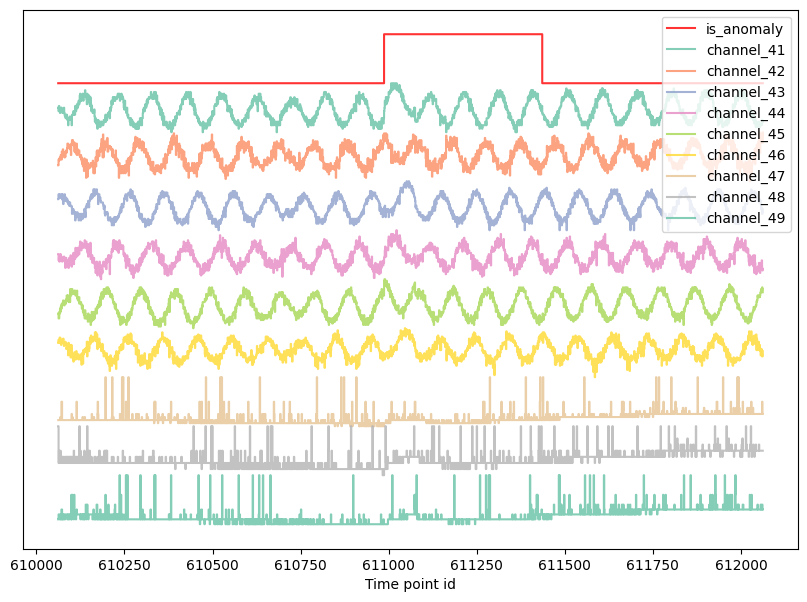

In [4]:
plt.rcParams["image.cmap"] = "Set2"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors)
plt.figure(figsize=(10,7))

start_idx = 610062
end_idx = start_idx + 2000

channel_names = [f"channel_{x}" for x in range(41,50)]

plt.step(train_df.loc[start_idx:end_idx, "id"], train_df.loc[start_idx:end_idx, "is_anomaly"] + 1, alpha=0.8, label="is_anomaly", where="post", color="red")

for i, channel in enumerate(channel_names):
    d = train_df.loc[start_idx:end_idx, channel]
    d = (d - np.min(d))/(np.max(d) - np.min(d))

    plt.step(train_df.loc[start_idx:end_idx, "id"], d - i, alpha=0.8, label=channel, where="post")

plt.xlabel("Time point id")
plt.yticks([], [])
plt.legend(loc="upper right")

In [5]:
# Select the channels that contain functional data
#channel_names = [f"channel_{x}" for x in [12, 13, 17, 18, 19, 20, 25, 26, 27, 28, 34, 35, 36, 37, 41, 42, 43, 44, 45, 46, ]]
channel_names = [f"channel_{x}" for x in [42, 43, 44, 45, 46]]

x_train = train_df[channel_names]
y_train = train_df["is_anomaly"]

## 2. Preprocess and smooth the data containing noise.
We use a rolling median centered to remove the noise of the data. Next, we standarize the data, i.e., $\tilde{X}_i(t) := \frac{X_i(t)- \mu_i}{\sigma_i}$.

The preprocess takes several minutes, hence, we store the result to avoid executing it several times.

In [6]:
#x_train = x_train.rolling(15, center=True).median()
#x_train = (x_train - x_train.mean()) / x_train.std()
#x_train.to_pickle("data/esa-adb-challenge/x_train_mini.pkl")
x_train = pd.read_pickle("data/esa-adb-challenge/x_train.pkl")
x_train = x_train[channel_names]

In [7]:
x_train.describe()

,channel_42,channel_43,channel_44,channel_45,channel_46
count,1.472831e+07,1.472831e+07,1.472831e+07,1.472831e+07,1.472831e+07
mean,-1.756621e-15,1.054966e-15,-1.213579e-15,-2.301246e-16,-1.718424e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.532174e+01,-2.409692e+01,-2.297262e+01,-2.582097e+01,-2.519210e+01
25%,-1.250101e-01,-6.984318e-02,-7.786586e-02,-9.170119e-02,-1.277817e-01
50%,5.703568e-02,5.419594e-02,5.879994e-02,4.336733e-02,3.890981e-02
75%,2.390370e-01,1.782351e-01,1.954261e-01,2.054754e-01,2.333365e-01
max,5.751925e+00,5.636033e+00,5.114890e+00,6.013817e+00,6.234048e+00


## 3. Estimate the Covariance matrix

Firstly, we need to choose a window size `N`. The covariance matrix is estimated using a batch procedure because doing a loop is expensive. The batch size is given by `bs` and the number of iterations is `n`.

We calculate both the covariance of the sample `cov` and the fourier transformation of the sample `cov_hat`, as well as the mean `mu` and `mu_hat`. Next, we store the results to avoid computing this slow procedure redundantly.

<div>
<img src="../images/sliding_window2.png" width="500"/>
</div>

In [8]:
N = 400 # window size
bs = 256 # batch size
n = 100 # iterations

In [9]:
# cov, mu = estimate_cov_mean(x_train, N, bs, n)
# cov_hat, mu_hat = estimate_fourier_cov_mean(x_train, N, bs, n)

# np.save("data/cov_mini.npy", cov)
# np.save("data/cov_hat_mini.npy", cov_hat)
# np.save("data/mu_mini.npy", mu)
# np.save("data/mu_hat_mini.npy", mu_hat)

cov = np.load("data/cov_mini.npy")
cov_hat = np.load("data/cov_hat_mini.npy")
mu = np.load("data/mu_mini.npy")
mu_hat = np.load("data/mu_hat_mini.npy")

In [10]:
fpca1 = FPCA()
ffpca1 = FFPCA()
fpca1.set_eigenvectors(cov)
fpca1.set_mean(mu)
ffpca1.set_eigenvectors(cov_hat)
ffpca1.set_mean(mu_hat)

## 4. Calculate the reconstruction error

In [11]:
t_start = 800000
t_step = 10
t_end = 2000000
t = np.arange(t_start, t_end, t_step)
r1, r2 = np.zeros_like(t, dtype=np.float32), np.zeros_like(t, dtype=np.float32)

def error(x1, x2):
    return np.mean(np.max(np.square(x1.real - x2.real), axis=0))

In [12]:
# for i, ti in tqdm(enumerate(t), total=len(t)):
#     x = np.expand_dims(x_train.loc[ti-N+1:ti].to_numpy(), axis=1)
#     y1 = fpca1.transform(x, 1)
#     y2 = ffpca1.transform(x, 1)

#     r1[i] = error(x, y1)
#     r2[i] = error(x, y2)

# error_df = pd.DataFrame({'fpca': r1, 'ffpca': r2}, index=t)
# error_df.to_pickle("data/error_df_mini.pkl")
error_df = pd.read_pickle("data/error_df_mini.pkl")

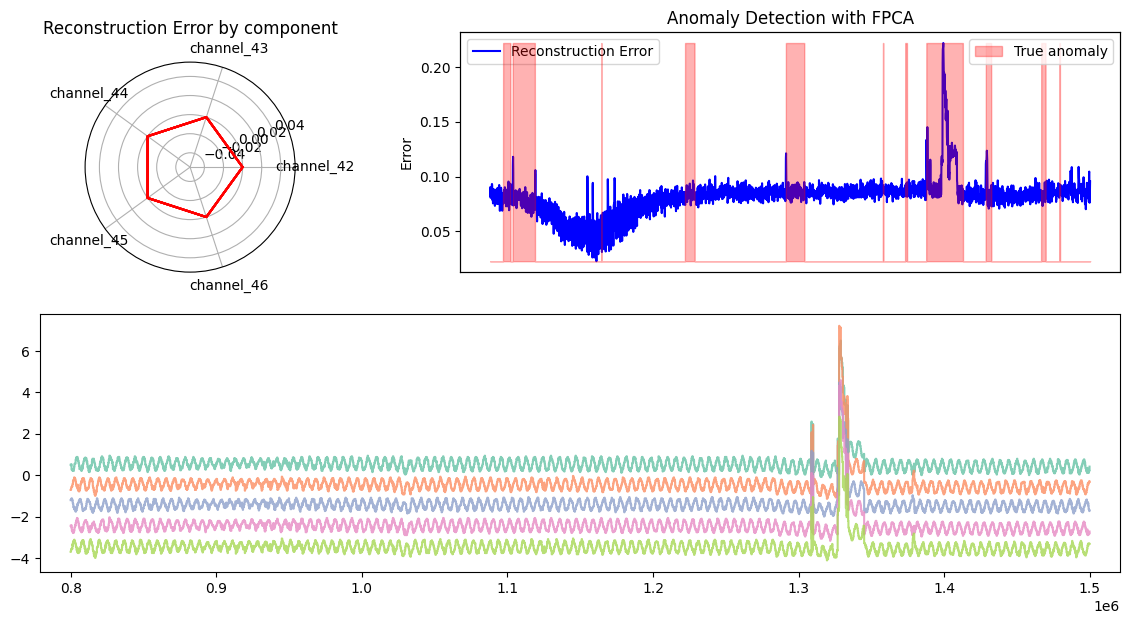

In [61]:
window_size = 40000
step = 200
t_start = 800000
t_end = 1500000


# Select data for this frame
y_train_loc = y_train.loc[np.arange(t_start,t_end,step)]
#df_error_selected = error_df.loc[(error_df.index >= t_start) & (error_df.index < t_end)]
df_error_selected = error_df.loc[np.arange(t_start, t_end, step)]
x_train_loc = x_train.loc[np.arange(t_start,t_end,step)]

fig = plt.figure(figsize=(12, 6))
ax2 = fig.add_axes([0.05, 0.55, 0.25, 0.35], polar=True)  # Polar plot on the left now
ax1 = fig.add_axes([0.4, 0.55, 0.55, 0.4])               # Regular plot on the right now
# New plot below both
ax3 = fig.add_axes([0.05, 0.05, 0.9, 0.43]) 

ax1_twin = ax1.twinx()
#ax1.set_xlabel('$t$')
ax1.set_ylabel('Error')
ax1_twin.set_yticks([])
fill = ax1_twin.fill_between(y_train_loc.index, 0, y_train_loc.values, color='red', alpha=0.3, label="True anomaly")
line = ax1.plot(df_error_selected.index, df_error_selected["fpca"].values, label="Reconstruction Error", color='blue')

r = np.linspace(0,2*np.pi,6)
#curve = ax2.plot(r, np.zeros(6))[0]

for i, channel in enumerate(channel_names):
    d = x_train.loc[800000:900000, channel]
    d = (x_train_loc.loc[t_start:t_end, channel] - np.min(d))/(np.max(d) - np.min(d))

    ax3.step(d.index, d - i, alpha=0.8, label=channel, where="post")


ax2.set_xticks(ticks=r[:-1],labels=channel_names)

ax1.set_title(f'Anomaly Detection with FPCA')
ax1.legend(loc='upper left')
ax1_twin.legend(loc='upper right')
ax1.set_xticks([])
ax3.margins(x=0.03)
ax1.margins(x=0.05)
ax2.set_title("Reconstruction Error by component")
#ax3.legend(loc='upper right')

curves = []
n_curves = 10
for i in range(n_curves):
    curve, = ax2.plot(r, np.zeros_like(r), alpha=np.exp(-i*0.1), c="red")  # faded for history
    curves.append(curve)

def update(frame, pbar):
    pbar.update(1)

    # Time window
    t1 = t_start + frame * step
    t2 = t1 + window_size
    t1_b = int(t2 - window_size*1.636)

    x = np.expand_dims(x_train.loc[t2-N+1:t2].to_numpy(), axis=1)
    y = fpca1.transform(x, 1)

    errors_i = np.mean(np.square(x-y),axis=(0,1))
    errors = np.append(errors_i, errors_i[0])
    
    # Shift old curves
    for i in range(n_curves-1):
        curves[i].set_ydata(curves[i + 1].get_ydata())
    curves[-1].set_ydata(errors)

    ax3.set_xlim((t1_b,t2))
    ax3.set_ylim((-4,1))
    ax1.set_ylim(bottom=0)
    ax1.set_xlim((t1,t2))
    ax2.set_ylim((0, 1.25*max(np.max(errors), 0.1)))


In [ ]:
frames = 3500
pbar = tqdm(total=frames)
ani = animation.FuncAnimation(fig, update, frames=frames, repeat=False, blit=False, fargs=(pbar,))
ani.save('images/animation_v7.mp4', fps=20)

11it [00:25,  2.30s/it] [00:00<?, ?it/s]
3501it [16:03,  3.47it/s]                          

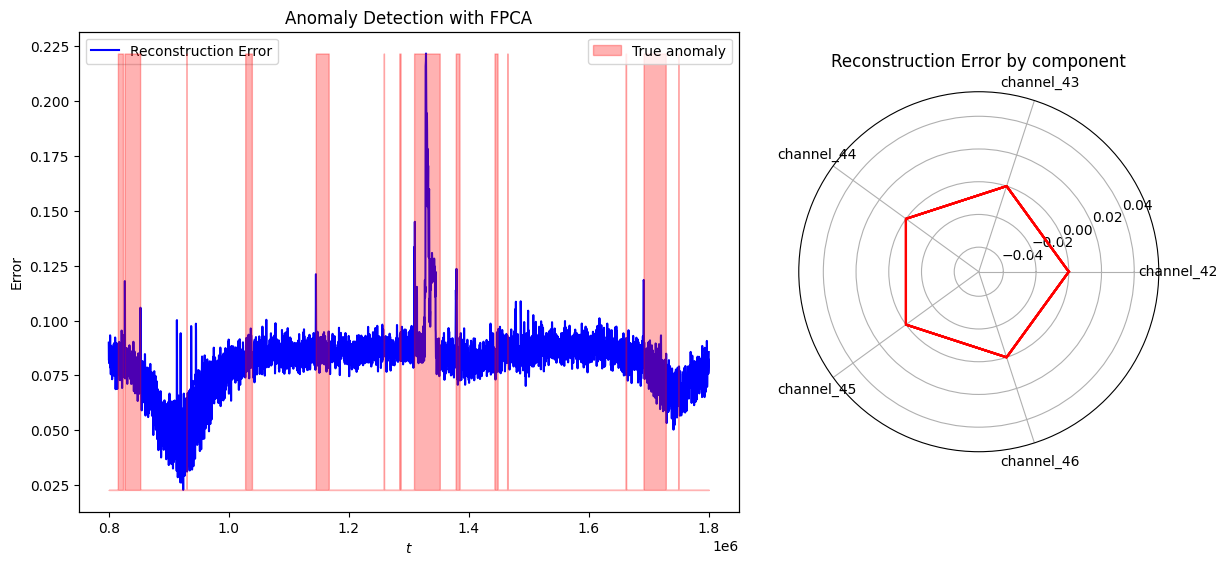

In [ ]:
window_size = 40000
step = 200
t_start = 800000
t_end = 1800000

# Select data for this frame
y_train_loc = y_train.loc[np.arange(t_start,t_end,step)]
#df_error_selected = error_df.loc[(error_df.index >= t_start) & (error_df.index < t_end)]
df_error_selected = error_df.loc[np.arange(t_start, t_end, step)]

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_axes([0.05, 0.1, 0.55, 0.8])
ax2 = fig.add_axes([0.65, 0.1, 0.3, 0.8], polar=True)

ax1_twin = ax1.twinx()
ax1.set_xlabel('$t$')
ax1.set_ylabel('Error')
ax1_twin.set_yticks([])
fill = ax1_twin.fill_between(y_train_loc.index, 0, y_train_loc.values, color='red', alpha=0.3, label="True anomaly")
line = ax1.plot(df_error_selected.index, df_error_selected["fpca"].values, label="Reconstruction Error", color='blue')

r = np.linspace(0,2*np.pi,6)
#curve = ax2.plot(r, np.zeros(6))[0]
ax2.set_xticks(ticks=r[:-1],labels=channel_names)

ax1.set_title(f'Anomaly Detection with FPCA')
ax1.legend(loc='upper left')
ax1_twin.legend(loc='upper right')

ax2.set_title("Reconstruction Error by component")

curves = []
n_curves = 10
for i in range(n_curves):
    curve, = ax2.plot(r, np.zeros_like(r), alpha=np.exp(-i*0.1), c="red")  # faded for history
    curves.append(curve)

def update(frame, pbar):
    pbar.update(1)

    # Time window
    t1 = t_start + frame * step
    t2 = t1 + window_size

    x = np.expand_dims(x_train.loc[t2-N+1:t2].to_numpy(), axis=1)
    y = fpca1.transform(x, 1)

    errors_i = np.mean(np.square(x-y),axis=(0,1))
    errors = np.append(errors_i, errors_i[0])
    
    # Shift old curves
    for i in range(n_curves-1):
        curves[i].set_ydata(curves[i + 1].get_ydata())
    curves[-1].set_ydata(errors)

    ax1.set_ylim(bottom=0)
    ax1.set_xlim((t1,t2))
    ax2.set
    ax2.set_ylim((0, 1.25*max(np.max(errors), 0.1)))



In [ ]:
frames = 5000
pbar = tqdm(total=frames)
ani = animation.FuncAnimation(fig, update, frames=frames, repeat=False, blit=False, fargs=(pbar,))
ani.save('animation_v4.mp4', fps=20)




5001it [32:12,  2.59it/s]














































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































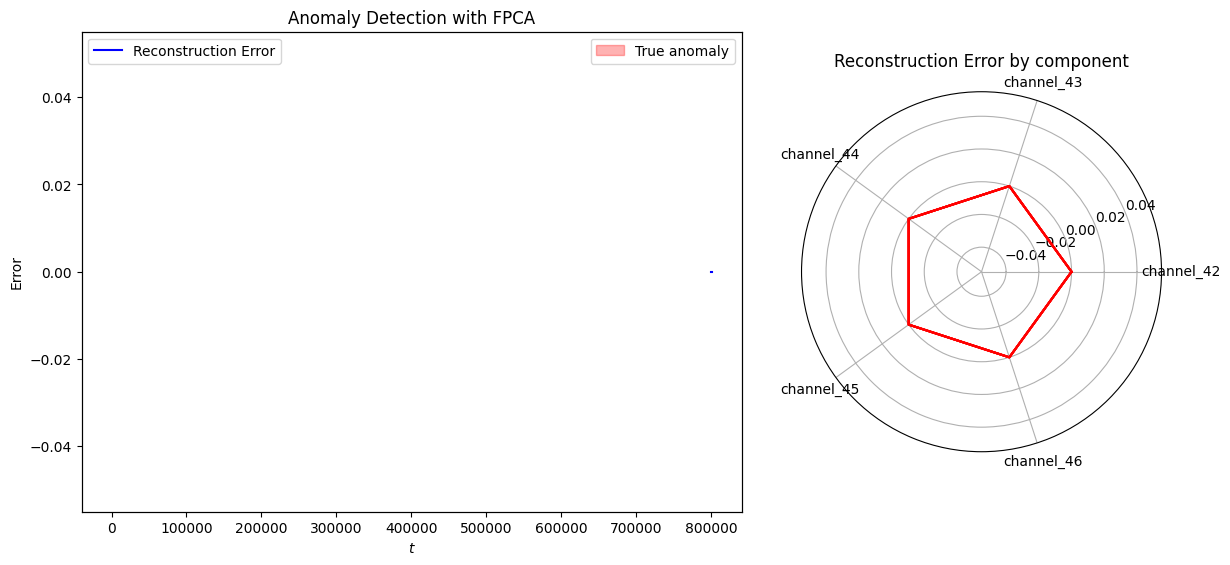

In [178]:
window_size = 20000
step = 10
t_start = 800000
t_end = 1300000

# Select data for this frame
y_train_loc = y_train.loc[t_start:t_end-1]
df_error_selected = error_df.loc[(error_df.index >= t1) & (error_df.index < t_end)]

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_axes([0.05, 0.1, 0.55, 0.8])
ax2 = fig.add_axes([0.65, 0.1, 0.3, 0.8], polar=True)

ax1_twin = ax1.twinx()
ax1.set_xlabel('$t$')
ax1.set_ylabel('Error')
ax1_twin.set_yticks([])
fill = ax1_twin.fill_between(np.zeros(window_size), 0, np.zeros(window_size), color='red', alpha=0.3, label="True anomaly")
line, = ax1.plot(np.arange(t_start,t_start+N), np.zeros(N), label="Reconstruction Error", color='blue')

r = np.linspace(0,2*np.pi,6)
ax2.set_xticks(ticks=r[:-1],labels=channel_names)

ax1.set_title(f'Anomaly Detection with FPCA')
ax1.legend(loc='upper left')
ax1_twin.legend(loc='upper right')

ax2.set_title("Reconstruction Error by component")

curves = []
n_curves = 10
for i in range(n_curves):
    curve, = ax2.plot(r, np.zeros_like(r), alpha=(n_curves-i)/n_curves, c="red")  # faded for history
    curves.append(curve)


def update(frame, pbar):
    pbar.update(1)
    
    # Time window
    t1 = t_start + frame * step
    t2 = t1 + window_size

    x = np.expand_dims(x_train.loc[t2-N+1:t2].to_numpy(), axis=1)
    y = fpca1.transform(x, 1)

    errors_i = np.mean(np.square(x-y),axis=(0,1))
    errors = np.append(errors_i, errors_i[0])
    
    # Shift old curves
    for i in range(n_curves-1):
        curves[i].set_ydata(curves[i + 1].get_ydata())
    curves[-1].set_ydata(errors)
    # # Select data for this frame
    y_train_loc = y_train.loc[t1:t2-1]
    df_error_selected = error_df.loc[(error_df.index >= t1) & (error_df.index < t2)]
    # # Main plot
    fill.set_data(y_train_loc.index, 0, y_train_loc.values)
    line.set_data(df_error_selected.index, df_error_selected["fpca"].values)
    # path = fill.get_paths()[0]
    # verts = path.vertices
    # verts[window_size+2:-1, 1] = y_train_loc.values[::-1]
    # line.set_ydata(df_error_selected["fpca"].values)
    ax1.set_ylim(bottom=0)
    ax1.set_xlim((t1,t2))
    ax1.set_ylim((0,1))
    ax1_twin.set_ylim((0,1.25))
    ax2.set_ylim(bottom=0)



In [ ]:
frames = 10
pbar = tqdm(total=frames)
ani = animation.FuncAnimation(fig, update, frames=frames, repeat=False, blit=False, fargs=(pbar,))
ani.save('animation_v4.mp4', fps=30)

11it [00:20,  1.90s/it]00:00<?, ?it/s]
11it [00:02,  3.92it/s]                        